In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf 
from pandas_datareader import data as pdr
yf.pdr_override()

In [25]:
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.figsize']=[8,6]

In [28]:
import seaborn as sns

In [27]:
#sns.set_palette('viridis')

In [29]:
tickers =['SPY', 'TLT', 'RWR']

In [30]:
dataset = pd.DataFrame(index=pd.date_range(start='2010-01-01', end='2022-12-30', freq='B'))
for ticker in tickers:
    asset = yf.Ticker(ticker).history(start='2010-01-01', end='2022-12-30')[['Close']]
    asset.columns = [ticker]
    dataset = dataset.join(asset)

In [31]:
import pandas as pd

In [32]:
datasetreturns= np.log(dataset/dataset.shift(1))

In [33]:
import numpy as np

In [34]:
datasetreturns.describe()

,SPY,TLT,RWR
count,3153.000000,3153.000000,3153.000000
mean,0.000440,0.000141,0.000285
std,0.011160,0.009475,0.013893
min,-0.115886,-0.069011,-0.202247
25%,-0.003732,-0.005523,-0.005605
50%,0.000669,0.000530,0.000893
75%,0.005728,0.005727,0.007057
max,0.086731,0.072503,0.090170


<AxesSubplot:>

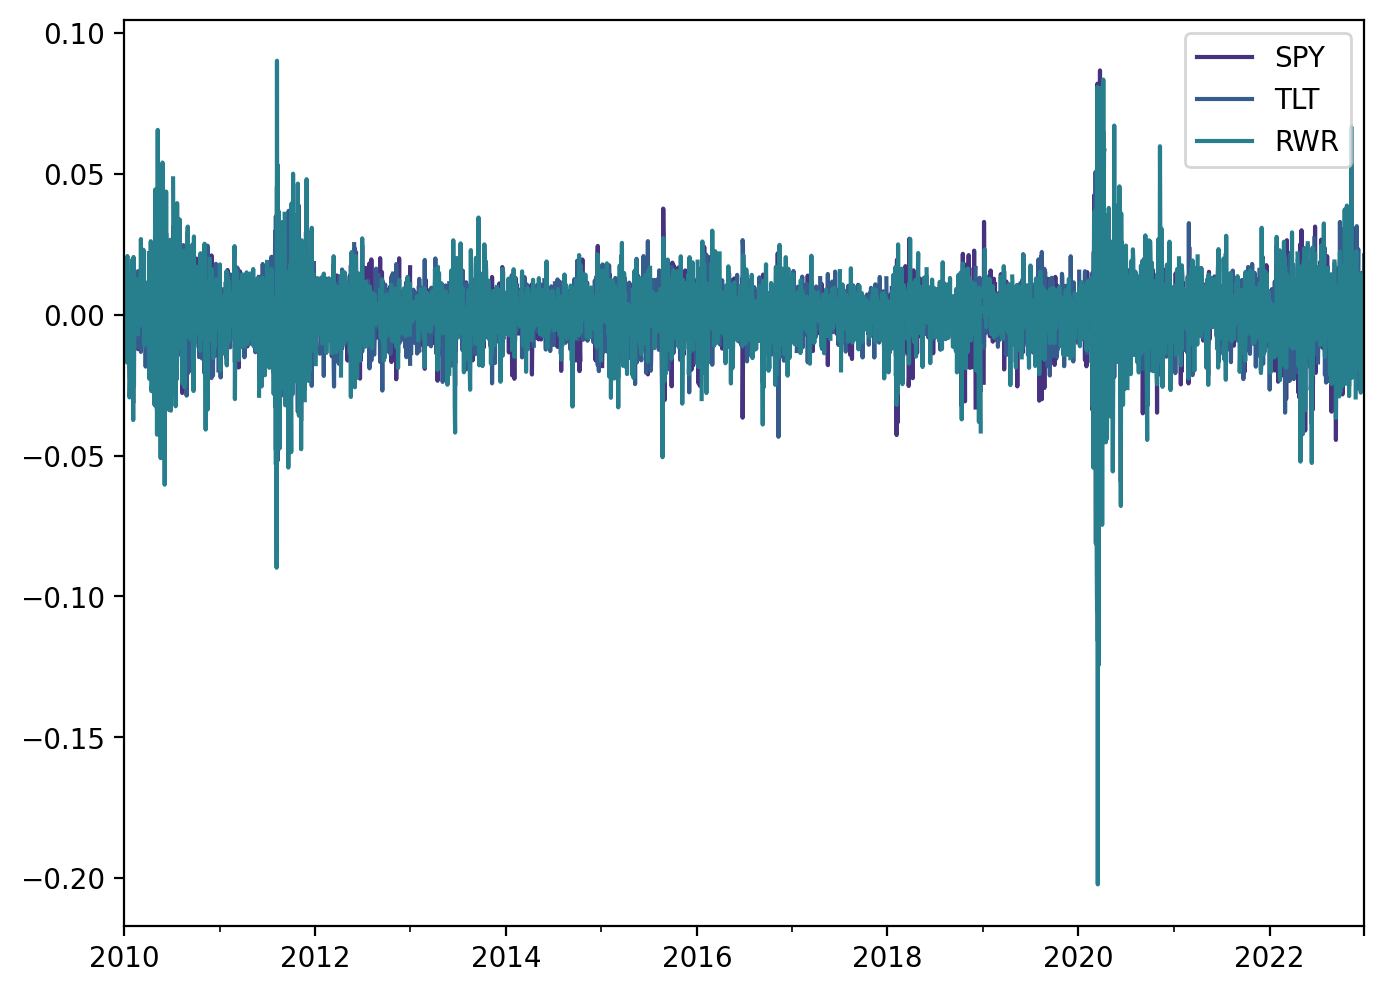

In [35]:
datasetreturns.plot()

<AxesSubplot:ylabel='Frequency'>

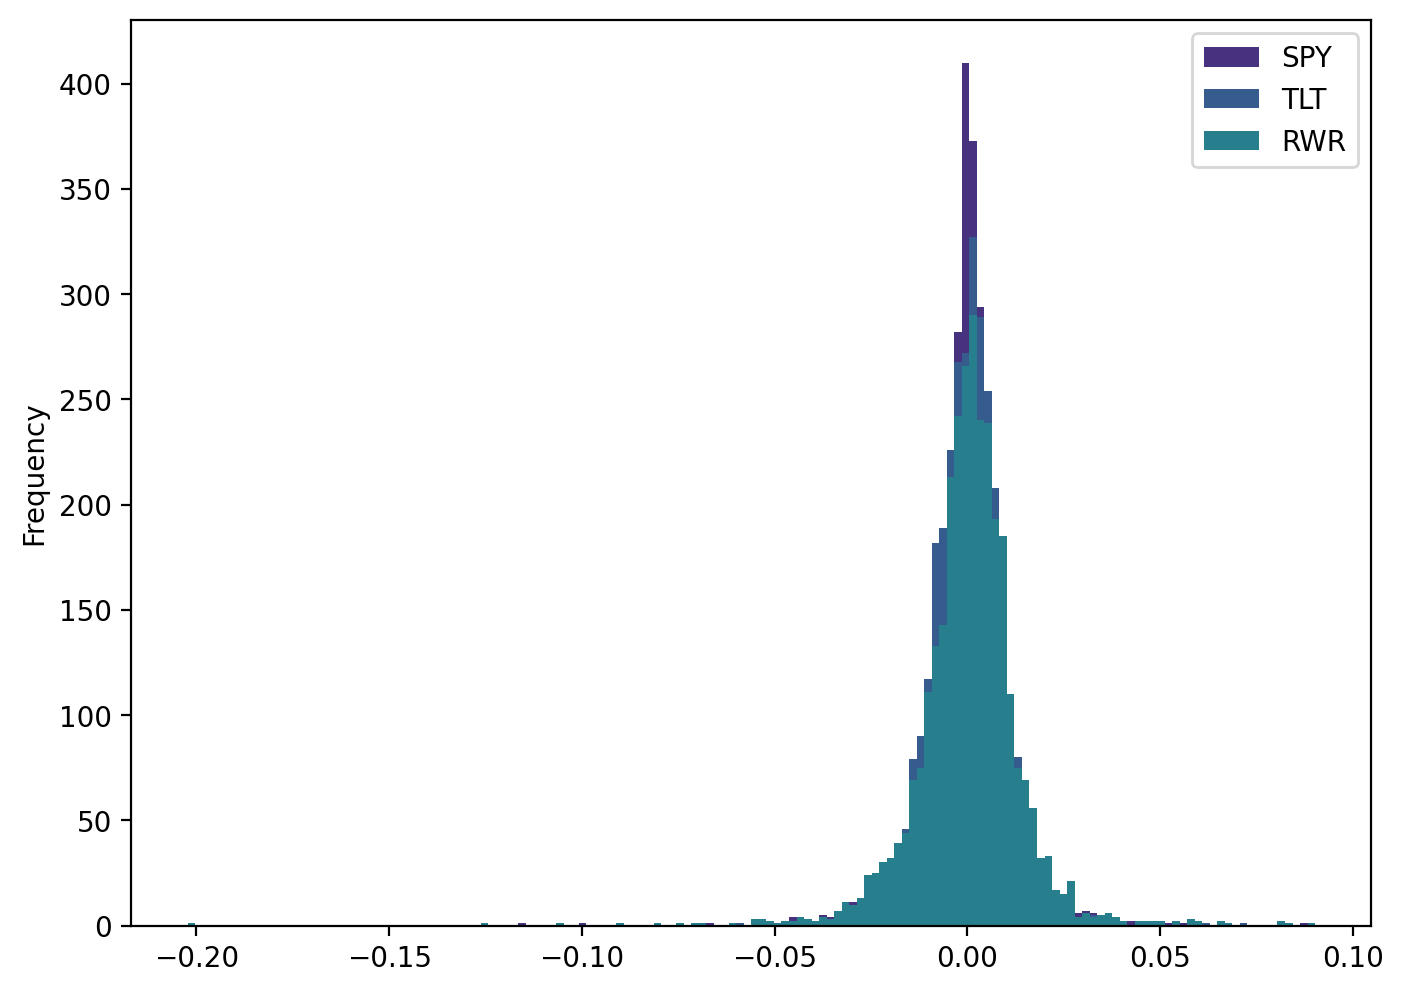

In [36]:
datasetreturns.plot(kind='hist', bins=150)

In [37]:
import matplotlib.pyplot as plt

<AxesSubplot:>

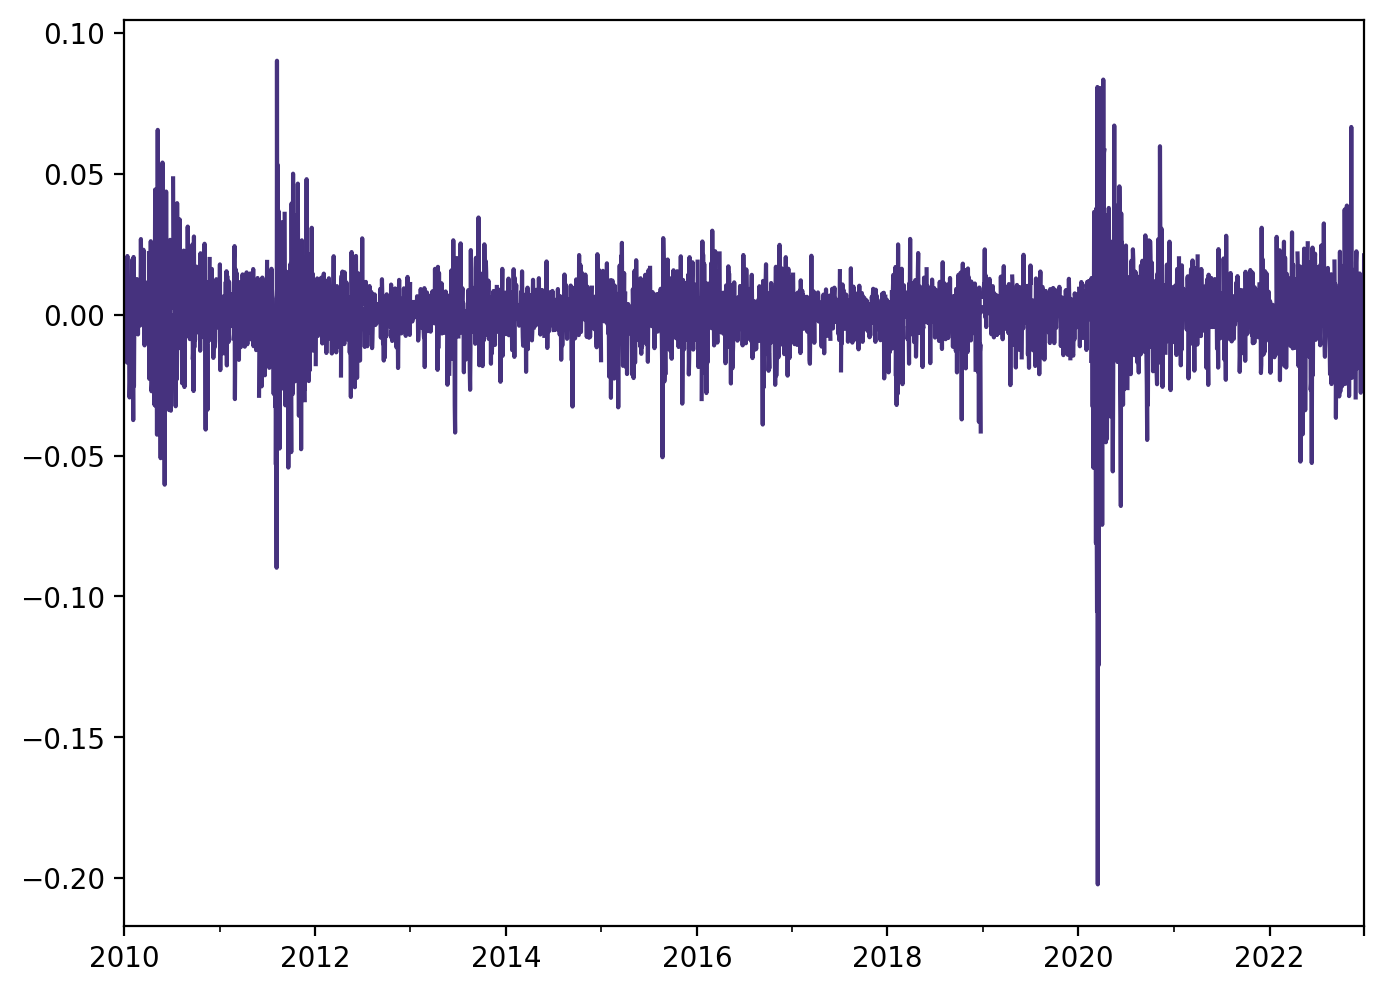

In [38]:
datasetreturns['RWR'].plot()

<AxesSubplot:>

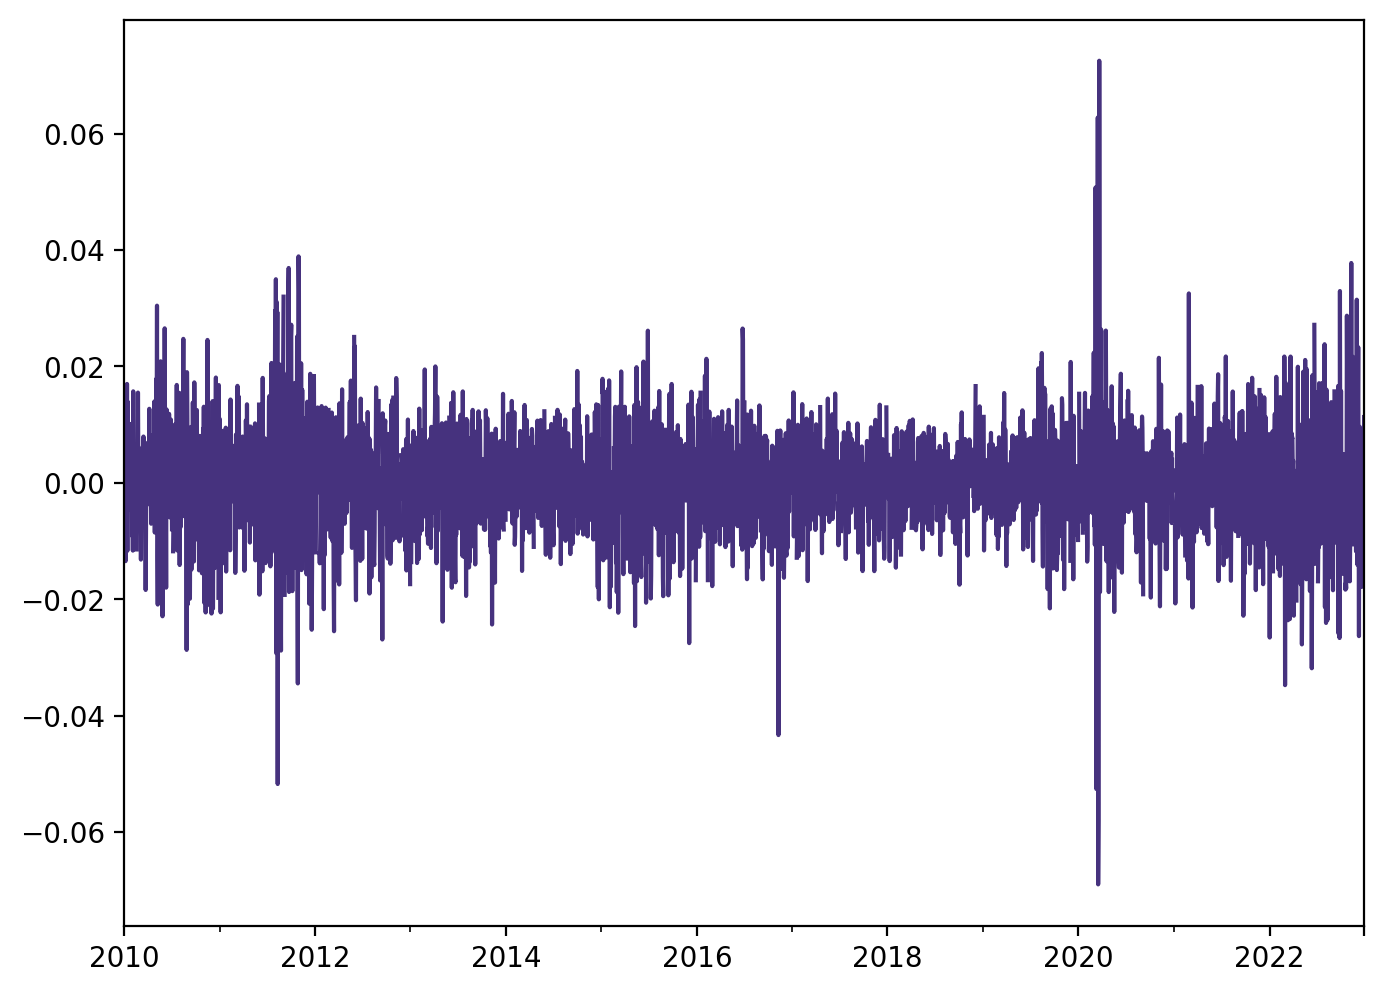

In [39]:
datasetreturns['TLT'].plot()

<AxesSubplot:>

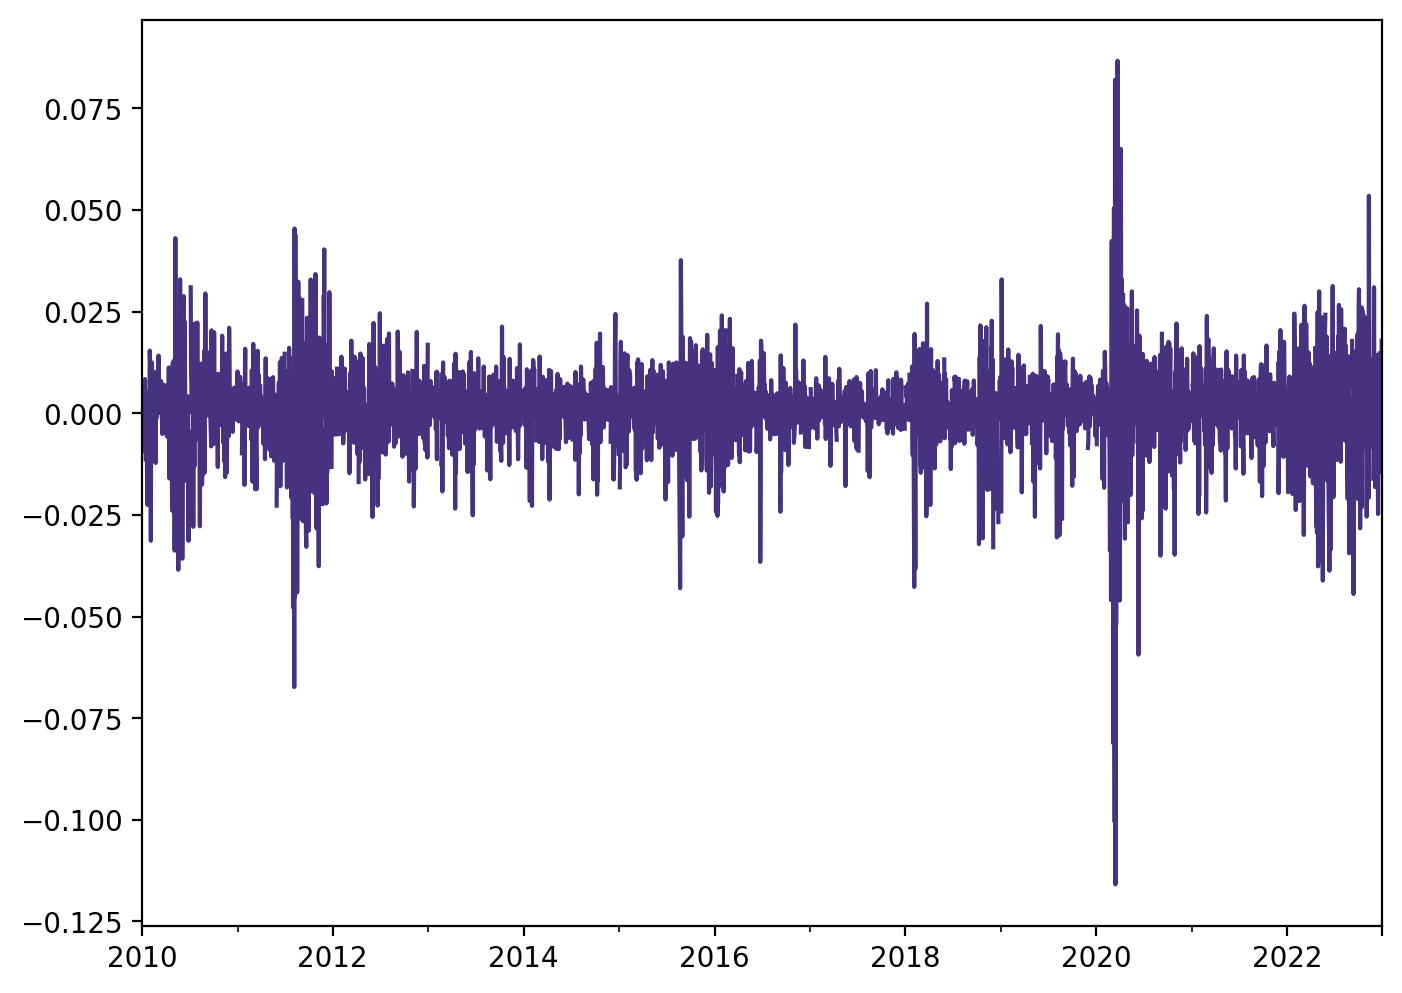

In [40]:
datasetreturns['SPY'].plot()

<AxesSubplot:>

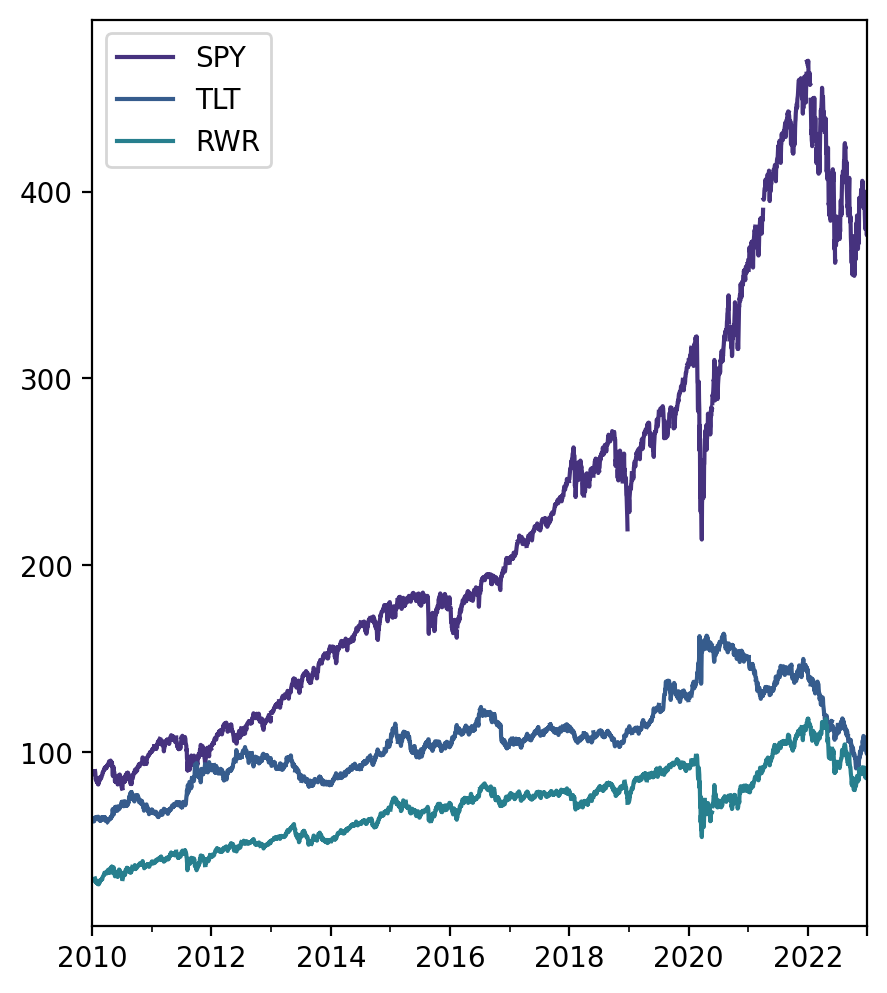

In [42]:
dataset.plot(figsize=(5,6))

In [43]:
dataset.dropna()/dataset.dropna().iloc[0]

,SPY,TLT,RWR
2010-01-04,1.000000,1.000000,1.000000
2010-01-05,1.002647,1.006458,1.000816
2010-01-06,1.003353,0.992985,1.000204
2010-01-07,1.007588,0.994655,1.009390
2010-01-08,1.010941,0.994209,1.000000
...,...,...,...
2022-12-22,4.304148,1.623309,2.733558
2022-12-23,4.328906,1.599511,2.756575
2022-12-27,4.311835,1.567884,2.755944
2022-12-28,4.258248,1.558646,2.705813


<AxesSubplot:>

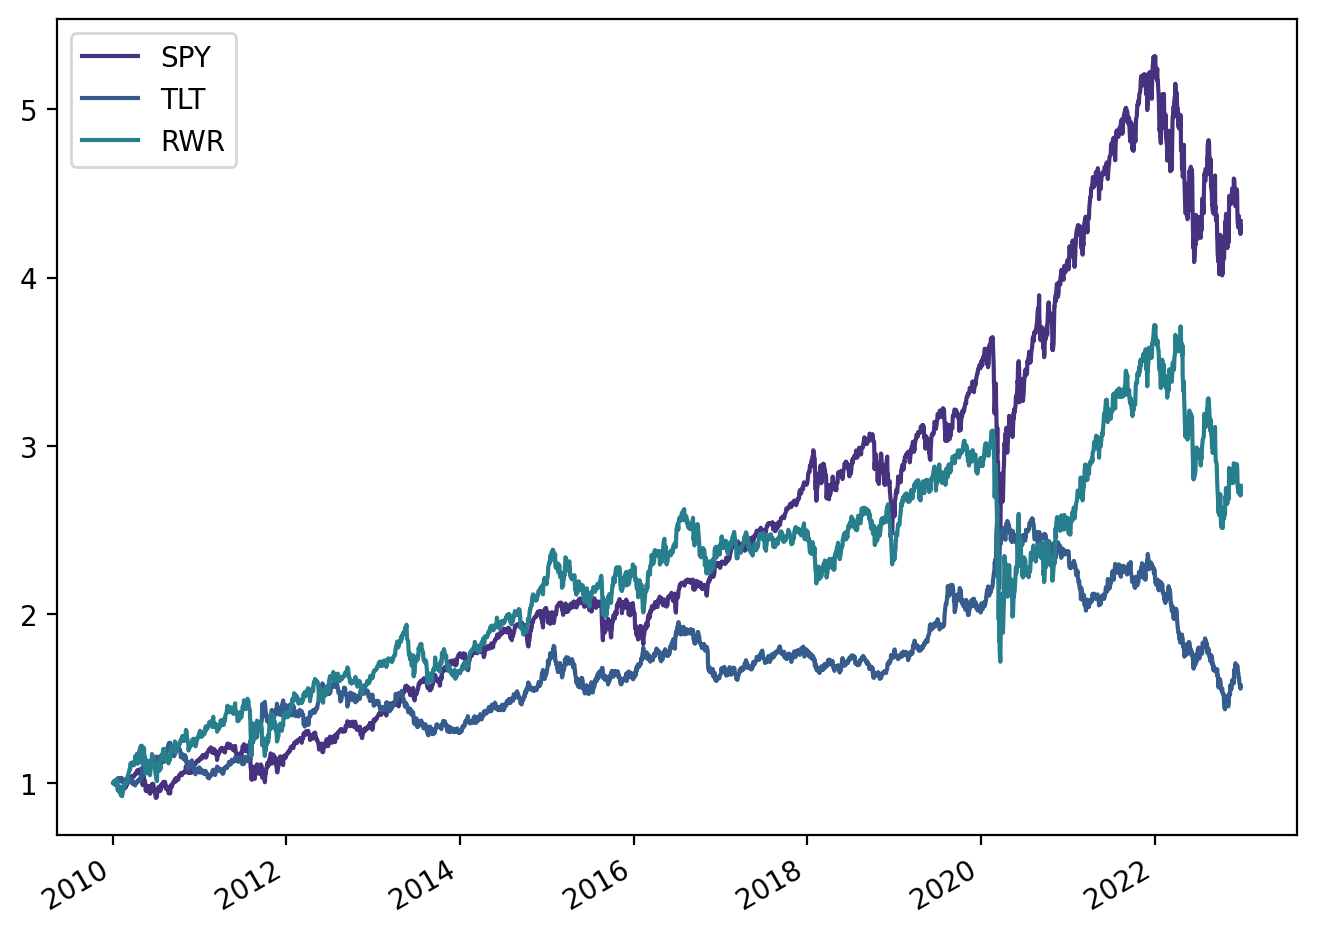

In [44]:
(dataset.dropna()/dataset.dropna().iloc[0]).plot()

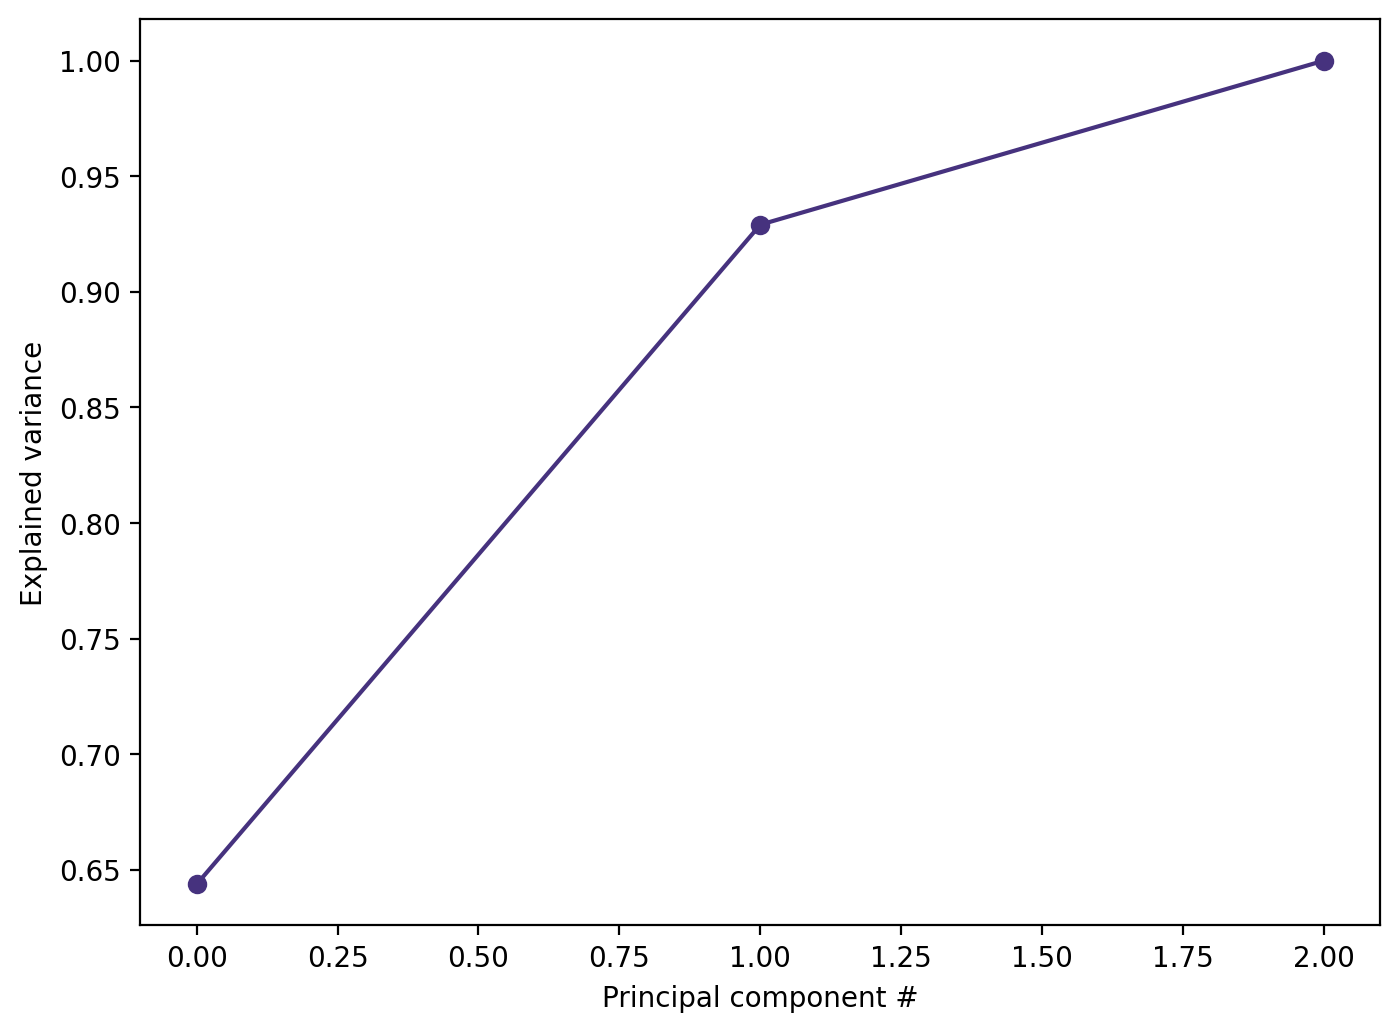

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(StandardScaler().fit_transform(datasetreturns.dropna()))
expl_var = pca.explained_variance_ratio_
pd.DataFrame(expl_var.cumsum()).plot(style='-o', legend=False)
plt.xlabel('Principal component #')
plt.ylabel('Explained variance')
plt.show()
     


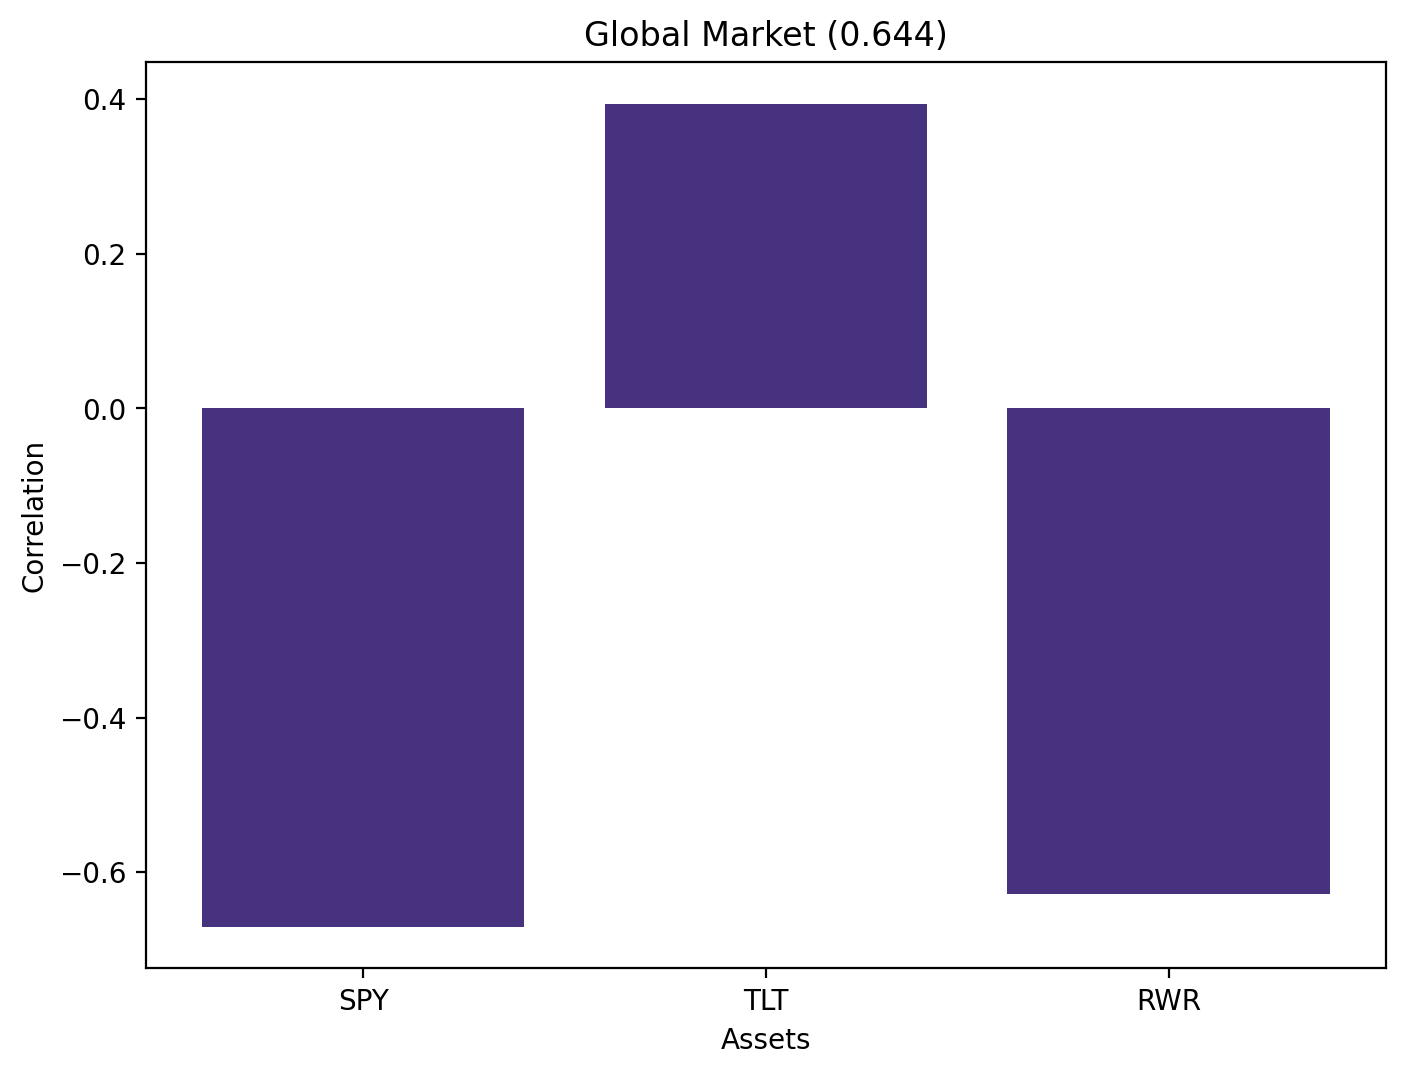

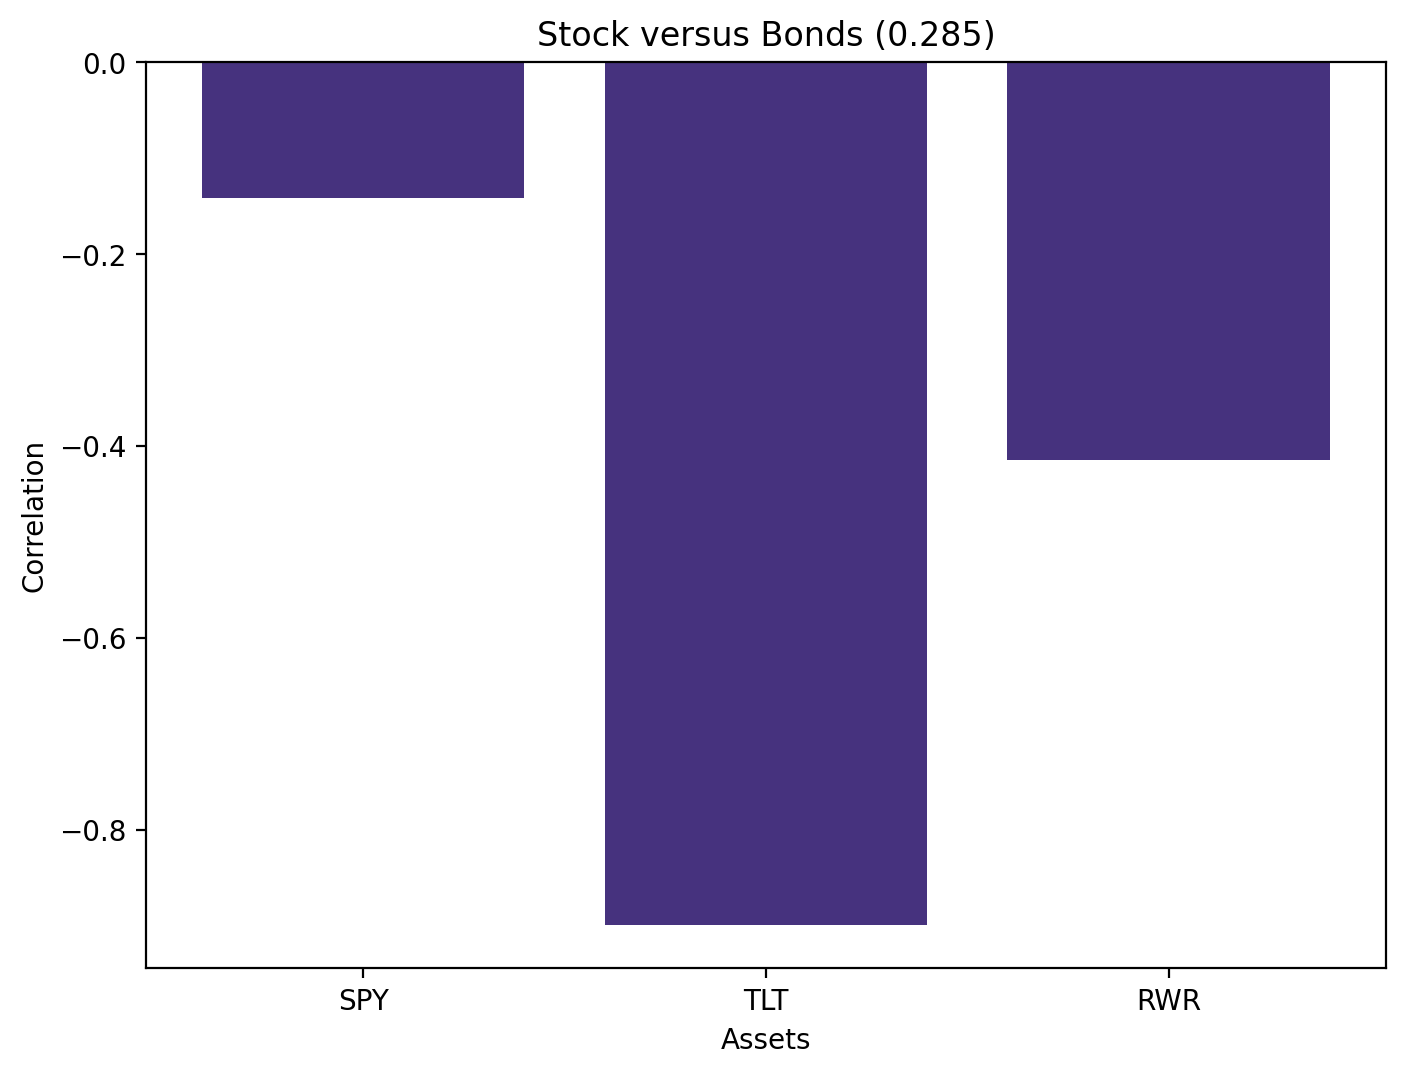

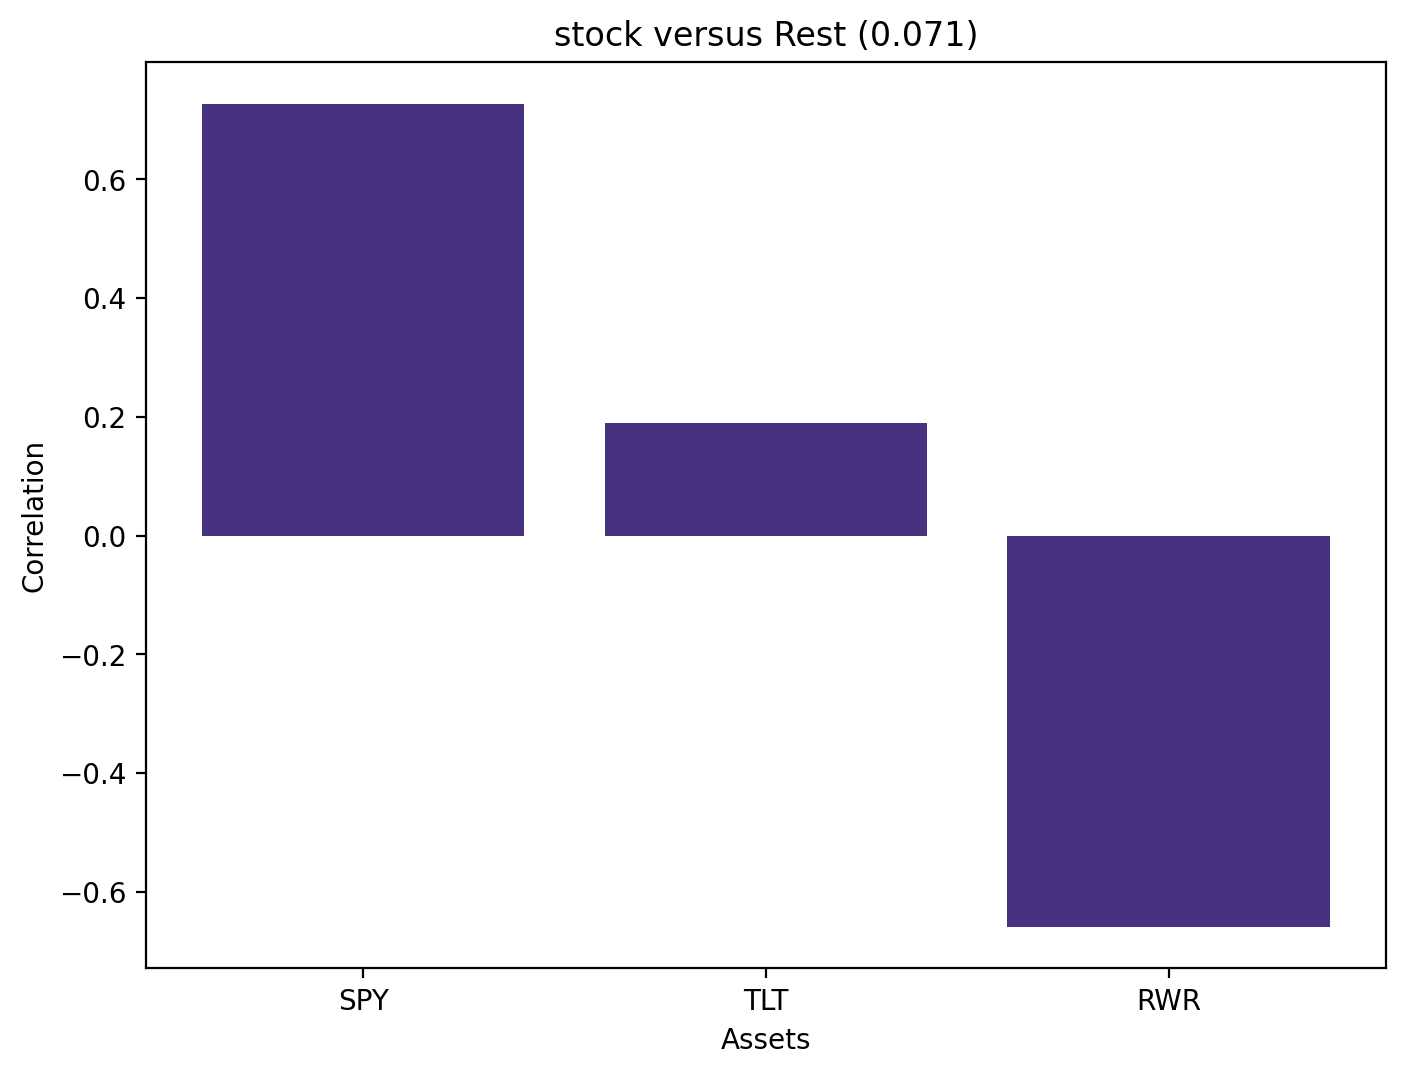

In [46]:
component_labels = {
    0: f'Global Market ({round(expl_var[0], 3)})',
    1: f'Stock versus Bonds ({round(expl_var[1], 3)})',
    2: f'stock versus Rest ({round(expl_var[2], 3)})',
    
}

for n, component in enumerate(pca.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xticks(dataset.columns)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()
     

In [47]:
pd.DataFrame({
    'Eigenvalues': pca.explained_variance_, 
    'Retain?': pca.explained_variance_ > 1,
    'Explained Variance': expl_var,
    'Cumulative Expl. Var.': expl_var.cumsum()
})

,Eigenvalues,Retain?,Explained Variance,Cumulative Expl. Var.
0,1.932001,True,0.643796,0.643796
1,0.856003,False,0.285244,0.929040
2,0.212948,False,0.070960,1.000000


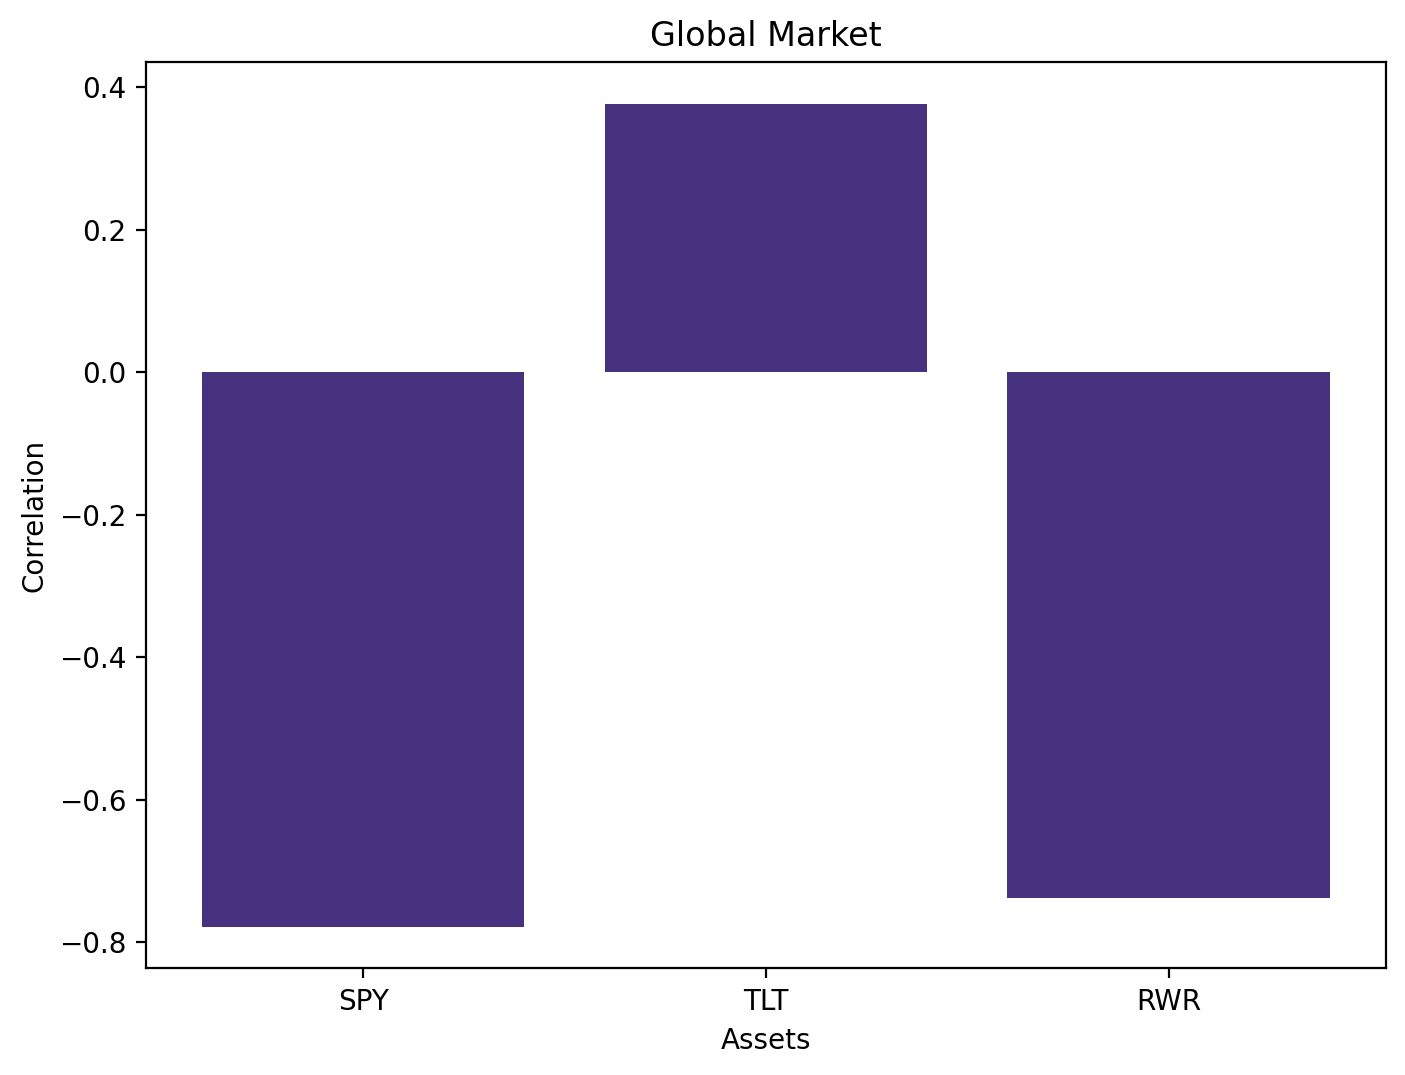

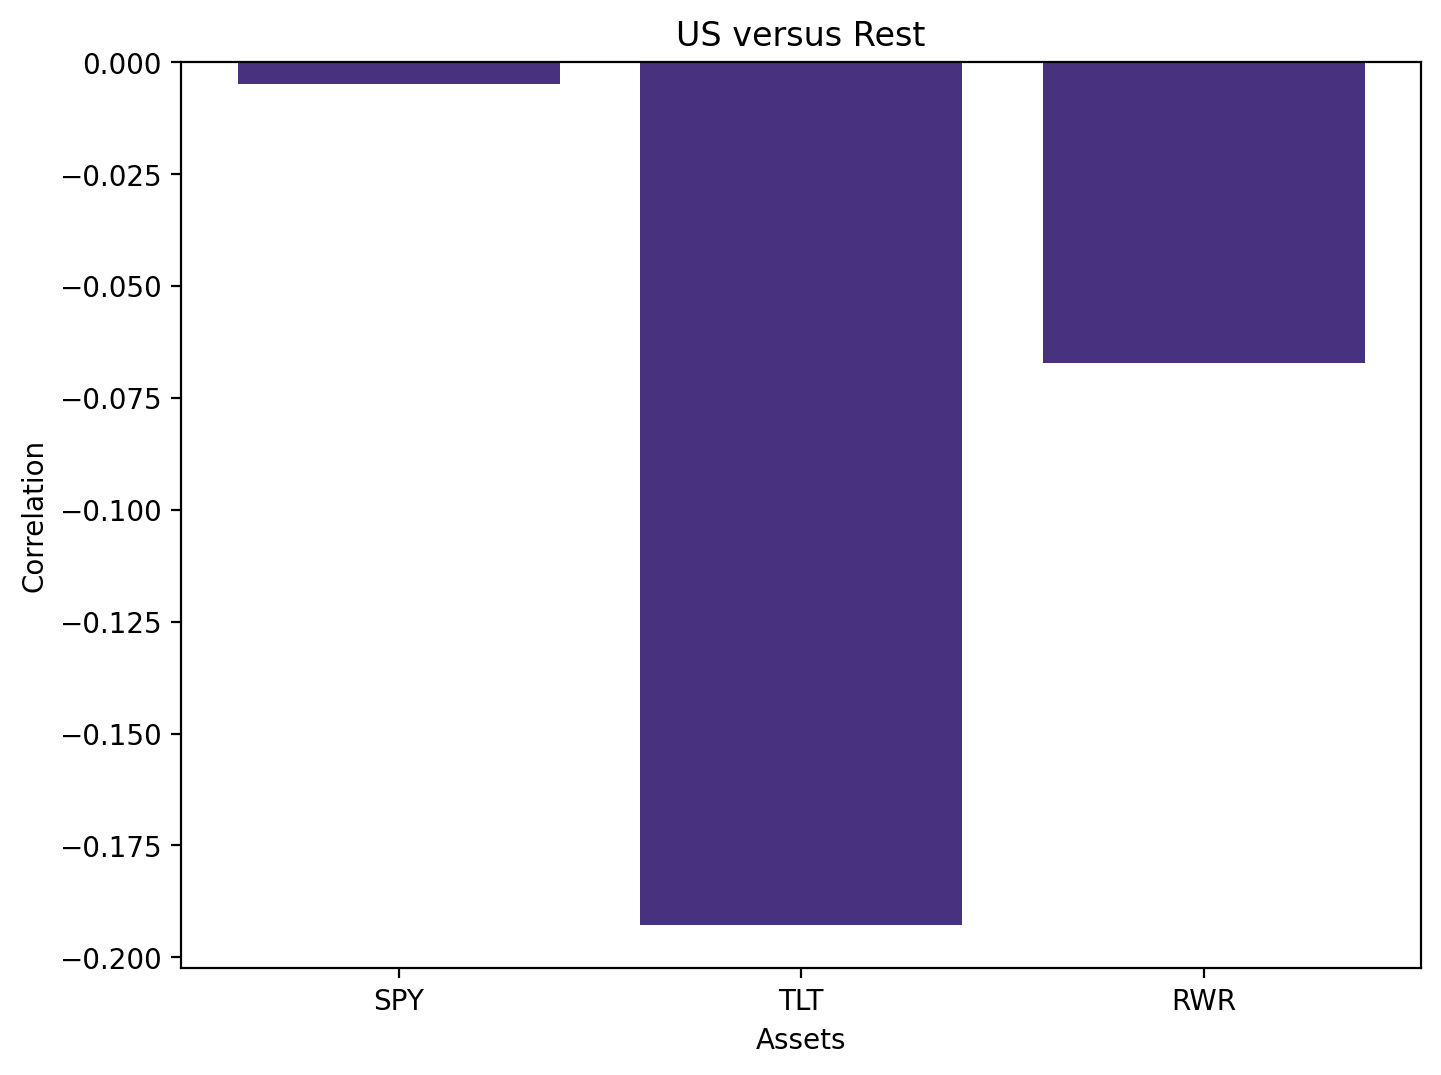

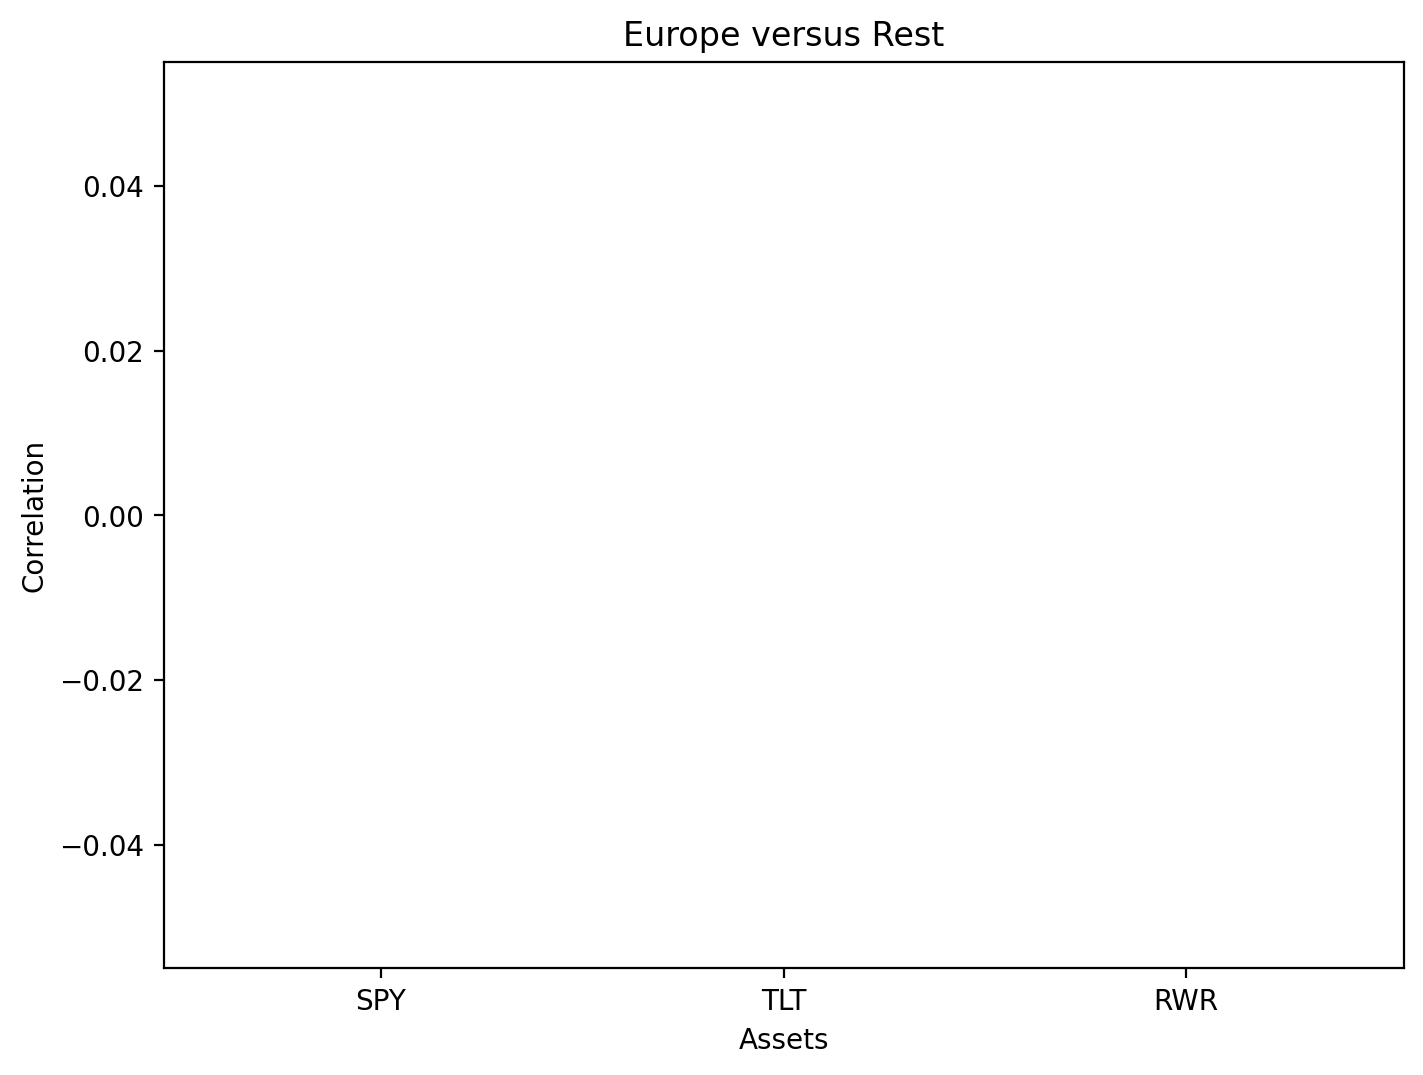

In [48]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis().fit(StandardScaler().fit_transform(datasetreturns.dropna()))

component_labels = {
    0: f'Global Market',
    1: f'US versus Rest',
    2: f'Europe versus Rest',
}

for n, component in enumerate(fa.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

In [49]:
(fa.components_.sum(axis=1) != 0).sum()


2

In [50]:
from itertools import combinations

# https://github.com/vinecopulib/pyvinecopulib
import pyvinecopulib as pv

# pyvinecopulib expects data to be pseudo-observations
# borrowing computer from https://github.com/DanielBok/copulae
from copulae.core import pseudo_obs

results = []
for pair in list(combinations(datasetreturns.dropna().columns, 2)):

    data = pseudo_obs(datasetreturns.dropna()[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    pair_results = {'pair': pair}
    for family in family_set:
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results[family.name.capitalize()] = copula.loglik()
    results.append(pair_results)
    
results = pd.DataFrame(results).set_index('pair')
     

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


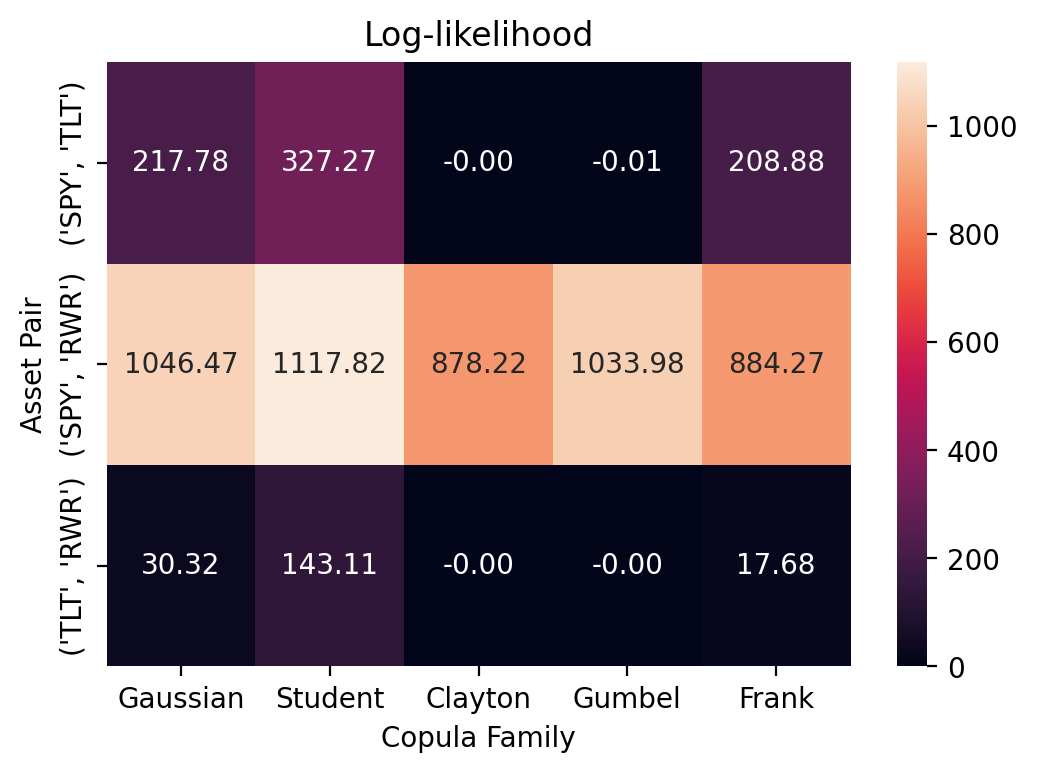

In [51]:
import seaborn as sb 
plt.figure(figsize=(6,4))
sb.heatmap(results.dropna(), annot=True, fmt='.2f')
plt.title('Log-likelihood')
plt.xlabel('Copula Family')
plt.ylabel('Asset Pair')
plt.show()

In [52]:
datasetreturns=datasetreturns.dropna()

In [53]:
results.idxmax(axis=1).value_counts()


Student    3
dtype: int64

In [54]:
def z_pdf(copula, x1, x2, zclip=30):
    """computes third dimension using pdf of fitted copula
    very rudimentary (slow!) implementation which could probably be vectorised
    inspired by https://github.com/blent-ai/pycopula/blob/master/pycopula/visualization.py
    """
    
    x1 = np.sort(x1)
    x2 = np.sort(x2)
    z= []
    for i in range(len(x1)):
        row = []
        for j in range(len(x2)):
            row.append(min(copula.pdf([[x1[i], x2[j] ]])[0], zclip))
        z.append(row)

    return x1, x2, np.asarray(z)

best_pair = results.max(axis=1).idxmax()
best_data = pseudo_obs(datasetreturns[[best_pair[0], best_pair[1]]])

best_copula = pv.Bicop(family=pv.BicopFamily.student)
best_copula.fit(best_data)

x1, x2 = best_data.iloc[:, 0], best_data.iloc[:, 1]
x1_s, x2_s, z = z_pdf(best_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

In [55]:
best_pair = results.max(axis=1).idxmax()

In [56]:
best_data = pseudo_obs(datasetreturns[[best_pair[0], best_pair[1]]])


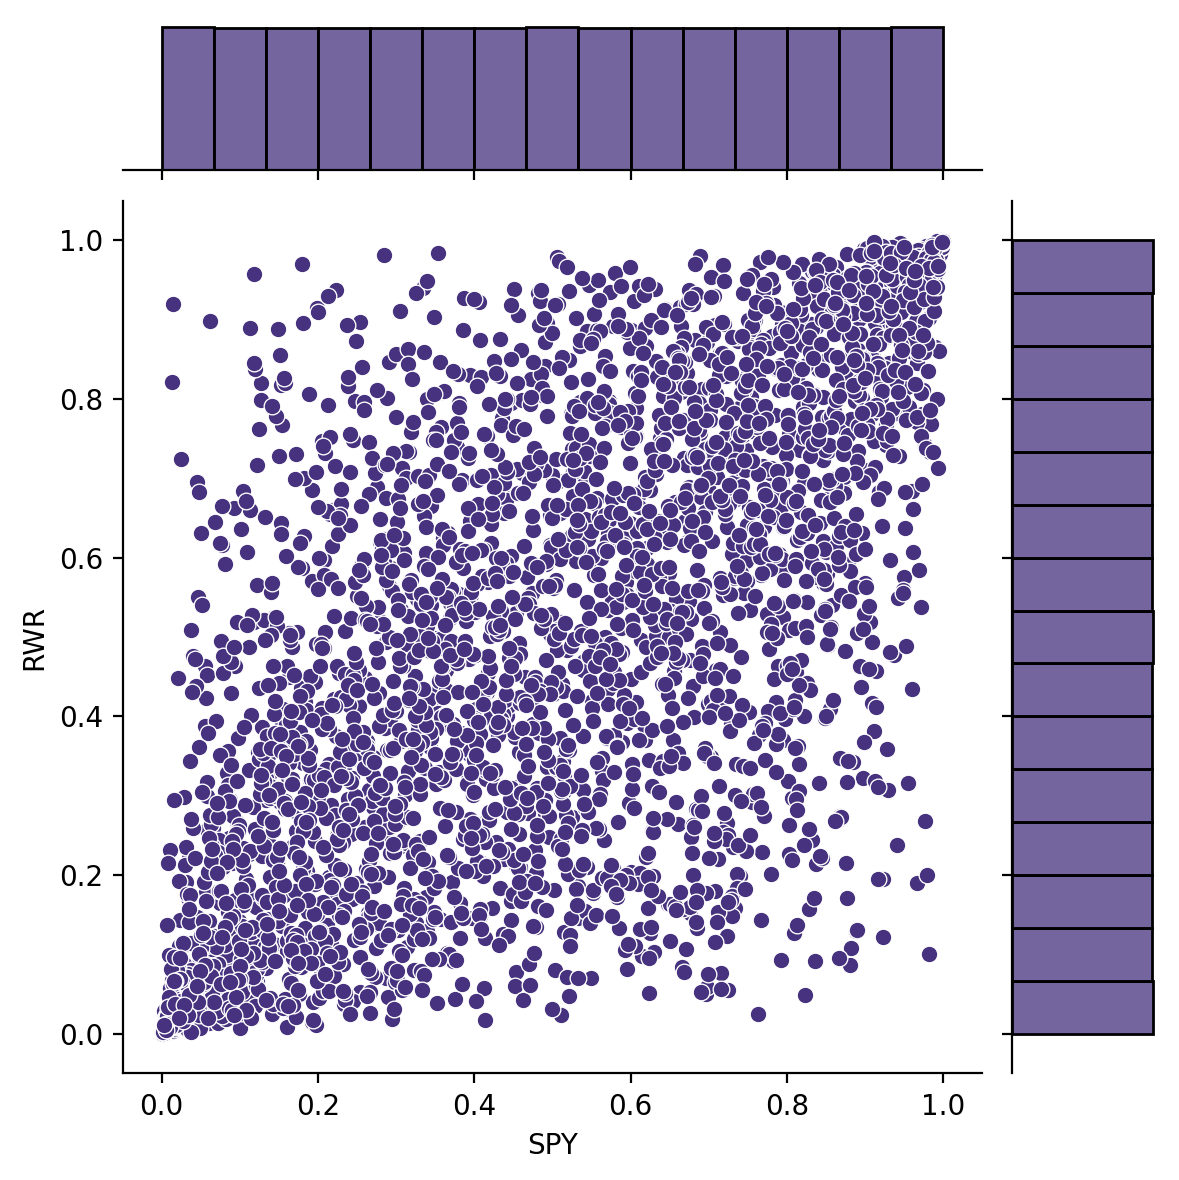

In [57]:
sb.jointplot(x=x1, y=x2, kind='scatter').set_axis_labels(best_pair[0], best_pair[1])
plt.show()
     

C:\Users\JAHANL~1\AppData\Local\Temp/ipykernel_11572/1942475716.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(plt.figure())


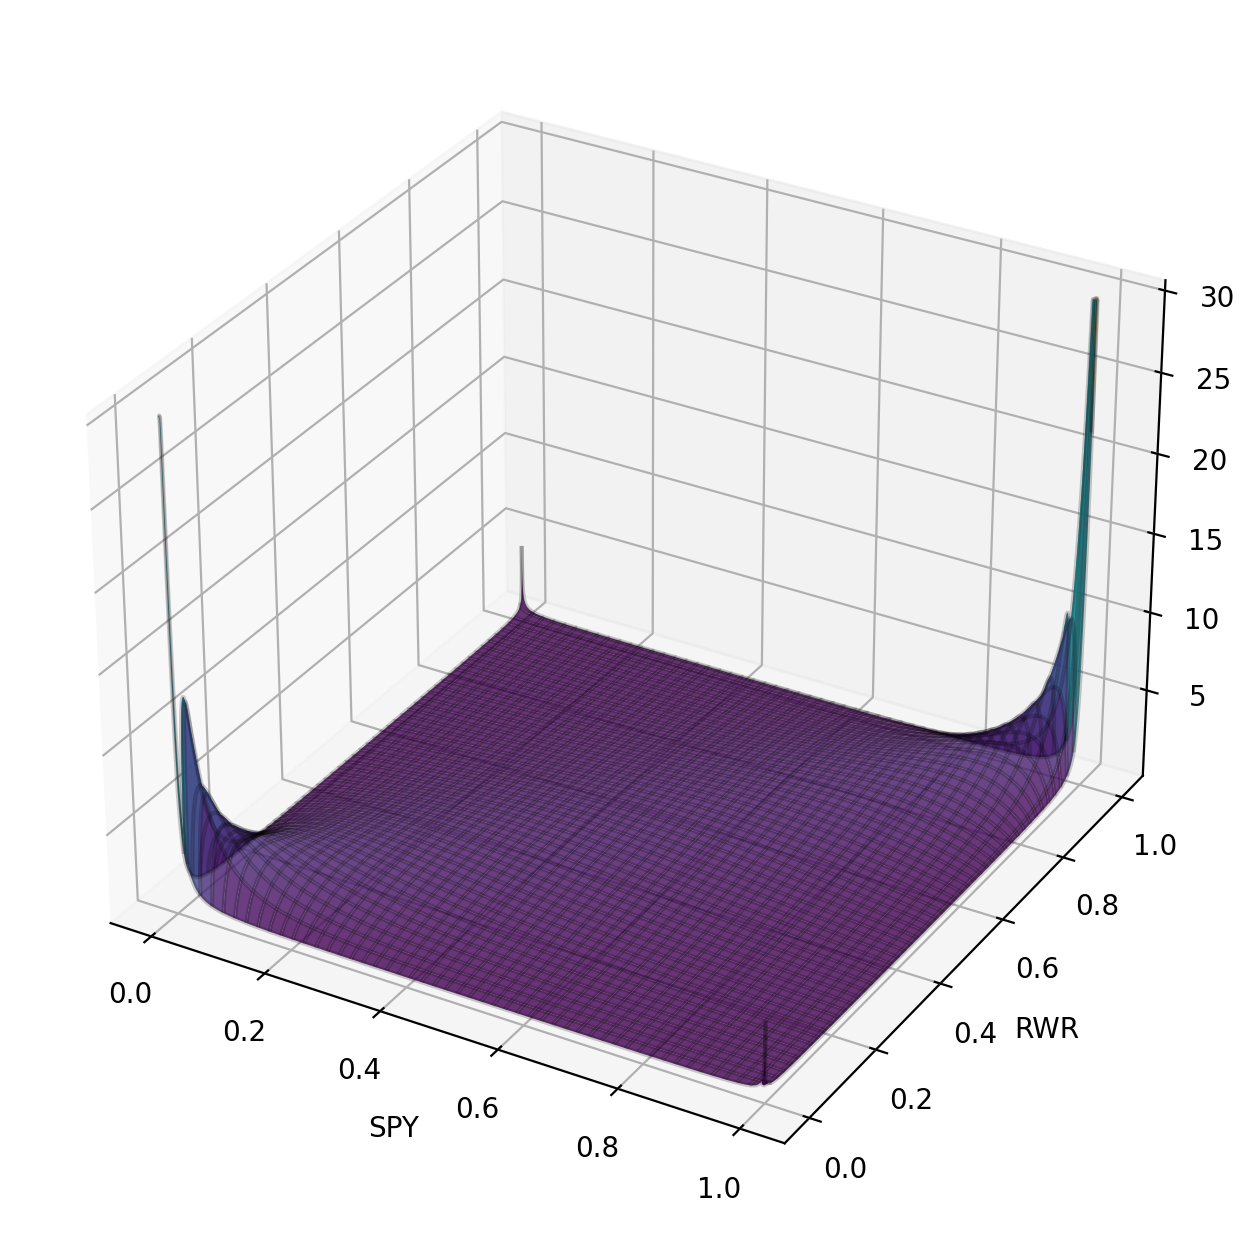

In [59]:
from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='viridis')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
ax.set_xlabel(best_pair[0])
ax.set_ylabel(best_pair[1])
plt.show()

C:\Users\jahan laptop\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


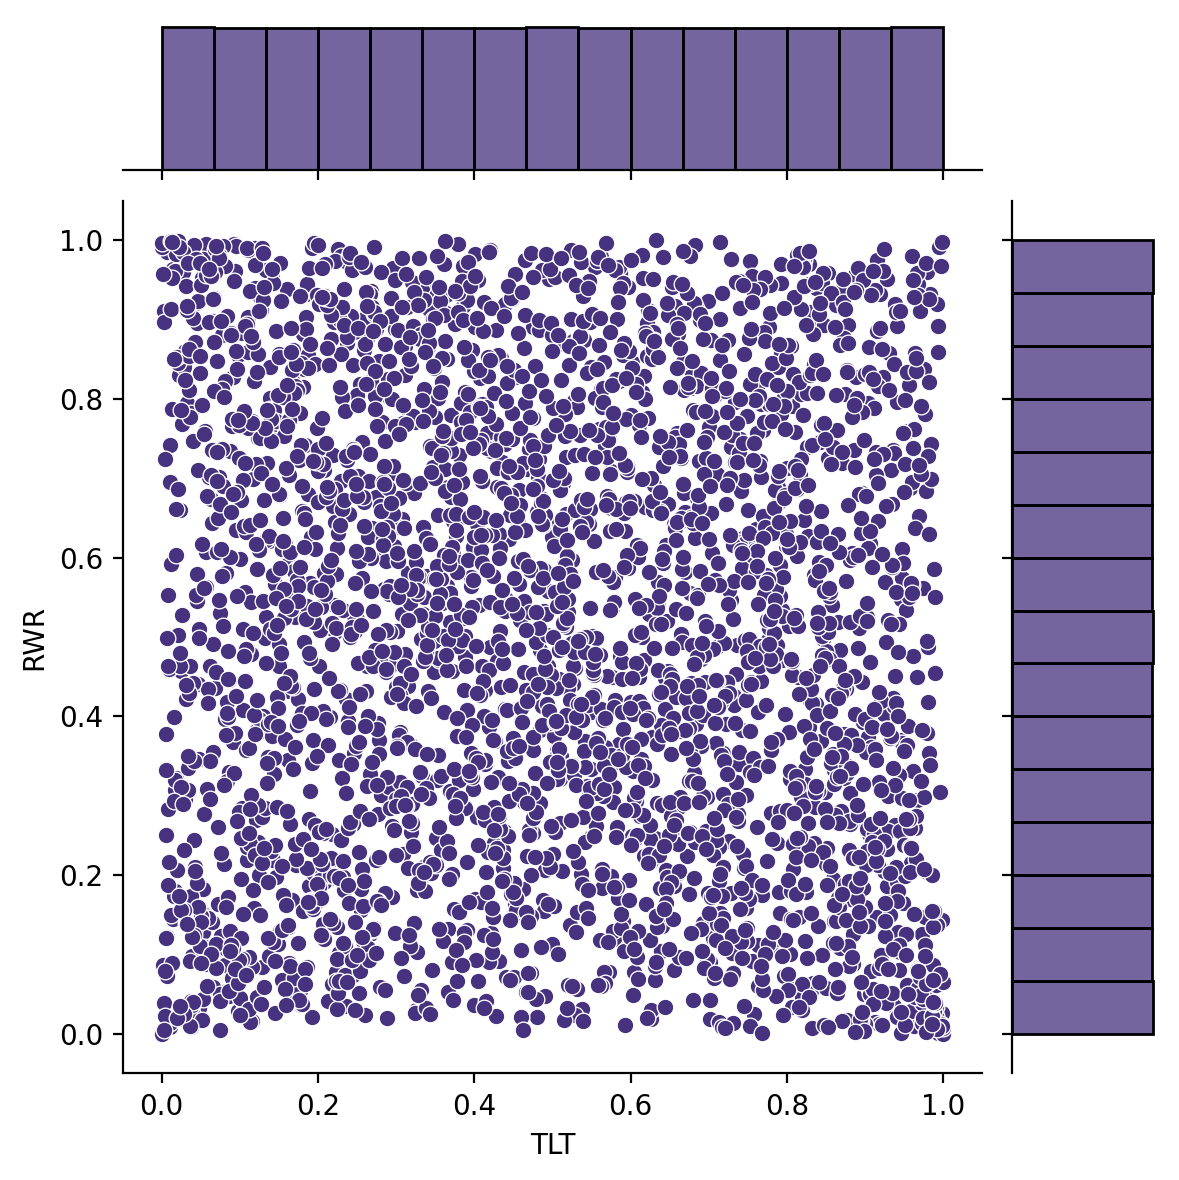

C:\Users\JAHANL~1\AppData\Local\Temp/ipykernel_11572/3115713894.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(plt.figure())


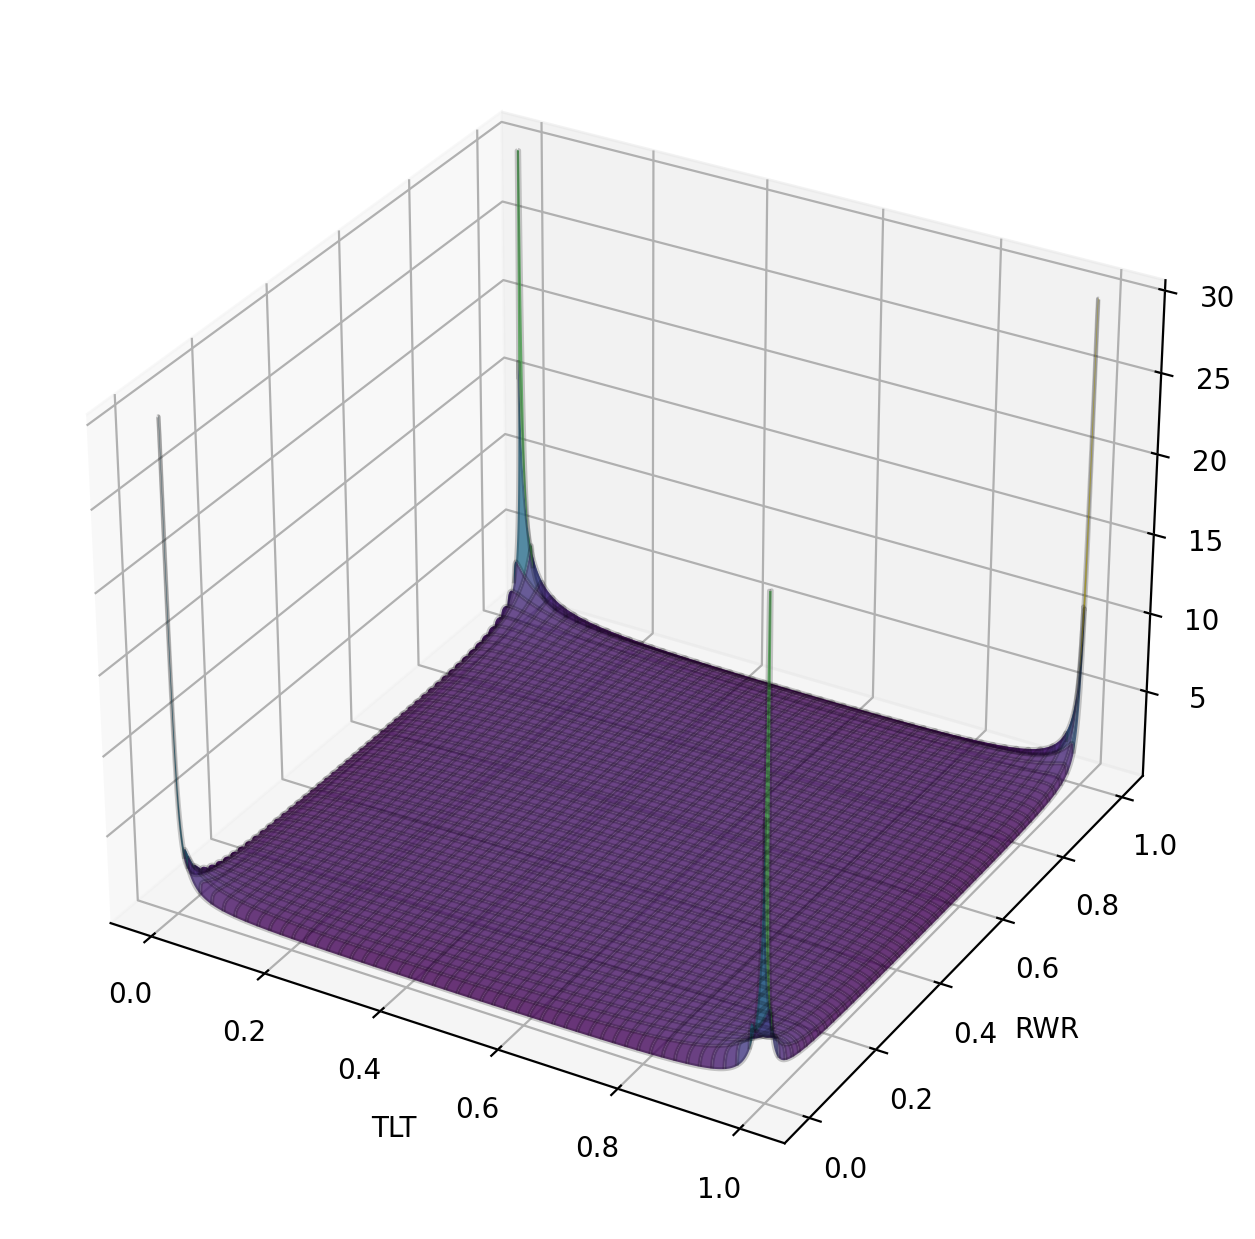

In [60]:
worst_pair = results.max(axis=1).idxmin()
worst_data = pseudo_obs(datasetreturns[[worst_pair[0], worst_pair[1]]])

worst_copula = pv.Bicop(family=pv.BicopFamily.student)
worst_copula.fit(worst_data)

x1, x2 = worst_data.iloc[:, 0], worst_data.iloc[:, 1]
x1_s, x2_s, z = z_pdf(worst_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

sb.jointplot(x1, x2, kind='scatter').set_axis_labels(worst_pair[0], worst_pair[1])
plt.show()

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='viridis')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
ax.set_xlabel(worst_pair[0])
ax.set_ylabel(worst_pair[1])
plt.show()

In [61]:
def print_parameters(pair):
    results = []
    data = pseudo_obs(datasetreturns.dropna()[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    print(pair)
    for family in family_set:
        pair_results = {}
        pair_results['family'] = family.name.capitalize()
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results['rho/beta'] = copula.parameters[0][0]
        try:
            pair_results['v'] = copula.parameters[1][0]
        except:
            pair_results['v'] = pd.NA
        pair_results['log-likelihood'] = copula.loglik()
        results.append(pair_results)
        
    return pd.DataFrame(results).set_index('family')


print_parameters(('RWR', 'TLT'))
     

('RWR', 'TLT')


,rho/beta,v,log-likelihood
family,,,
Gaussian,-0.138608,<NA>,30.316729
Student,-0.103482,3.175022,143.111398
Clayton,0.000002,<NA>,-0.000103
Gumbel,1.000004,<NA>,-0.000744
Frank,-0.666600,<NA>,17.677272


In [62]:
print_parameters(('RWR', 'SPY'))


('RWR', 'SPY')


,rho/beta,v,log-likelihood
family,,,
Gaussian,0.697577,<NA>,1046.466709
Student,0.682790,3.902425,1117.821960
Clayton,1.362101,<NA>,878.219855
Gumbel,1.895635,<NA>,1033.983057
Frank,5.338514,<NA>,884.267901


In [63]:
print_parameters(('SPY', 'TLT'))


('SPY', 'TLT')


,rho/beta,v,log-likelihood
family,,,
Gaussian,-0.360449,<NA>,217.784449
Student,-0.364887,3.507503,327.270273
Clayton,0.000002,<NA>,-0.001171
Gumbel,1.000005,<NA>,-0.005392
Frank,-2.346719,<NA>,208.875465


In [64]:
print_parameters(('TLT', 'SPY'))


('TLT', 'SPY')


,rho/beta,v,log-likelihood
family,,,
Gaussian,-0.360449,<NA>,217.784449
Student,-0.364887,3.507503,327.270273
Clayton,0.000002,<NA>,-0.001171
Gumbel,1.000005,<NA>,-0.005392
Frank,-2.346719,<NA>,208.875465


In [65]:
from scipy import stats

pd.DataFrame(
    {'Kurtosis': stats.kurtosis(datasetreturns)},
    index=dataset.columns
).sort_values(by='Kurtosis')
     

,Kurtosis
TLT,4.321374
SPY,11.728125
RWR,21.892103


In [66]:
from scipy import stats

pd.DataFrame(
    {'Skewness': stats.skew(datasetreturns)},
    index=dataset.columns
).sort_values(by='Skewness')
     

,Skewness
RWR,-1.361918
SPY,-0.772762
TLT,-0.005053


In [67]:
from scipy import stats

pd.DataFrame(
    {'Mean': np.mean(datasetreturns)},
    index=dataset.columns
).sort_values(by='Mean')
     

,Mean
TLT,0.000141
RWR,0.000285
SPY,0.000440


In [68]:
from scipy import stats

pd.DataFrame(
    {'Max': np.max(datasetreturns)},
    index=dataset.columns
).sort_values(by='Max')
     

,Max
TLT,0.072503
SPY,0.086731
RWR,0.090170


In [69]:
datasetreturns.describe()

,SPY,TLT,RWR
count,3153.000000,3153.000000,3153.000000
mean,0.000440,0.000141,0.000285
std,0.011160,0.009475,0.013893
min,-0.115886,-0.069011,-0.202247
25%,-0.003732,-0.005523,-0.005605
50%,0.000669,0.000530,0.000893
75%,0.005728,0.005727,0.007057
max,0.086731,0.072503,0.090170


In [70]:
datasetreturns.skew()

SPY   -0.773130
TLT   -0.005055
RWR   -1.362567
dtype: float64

<AxesSubplot:ylabel='Frequency'>

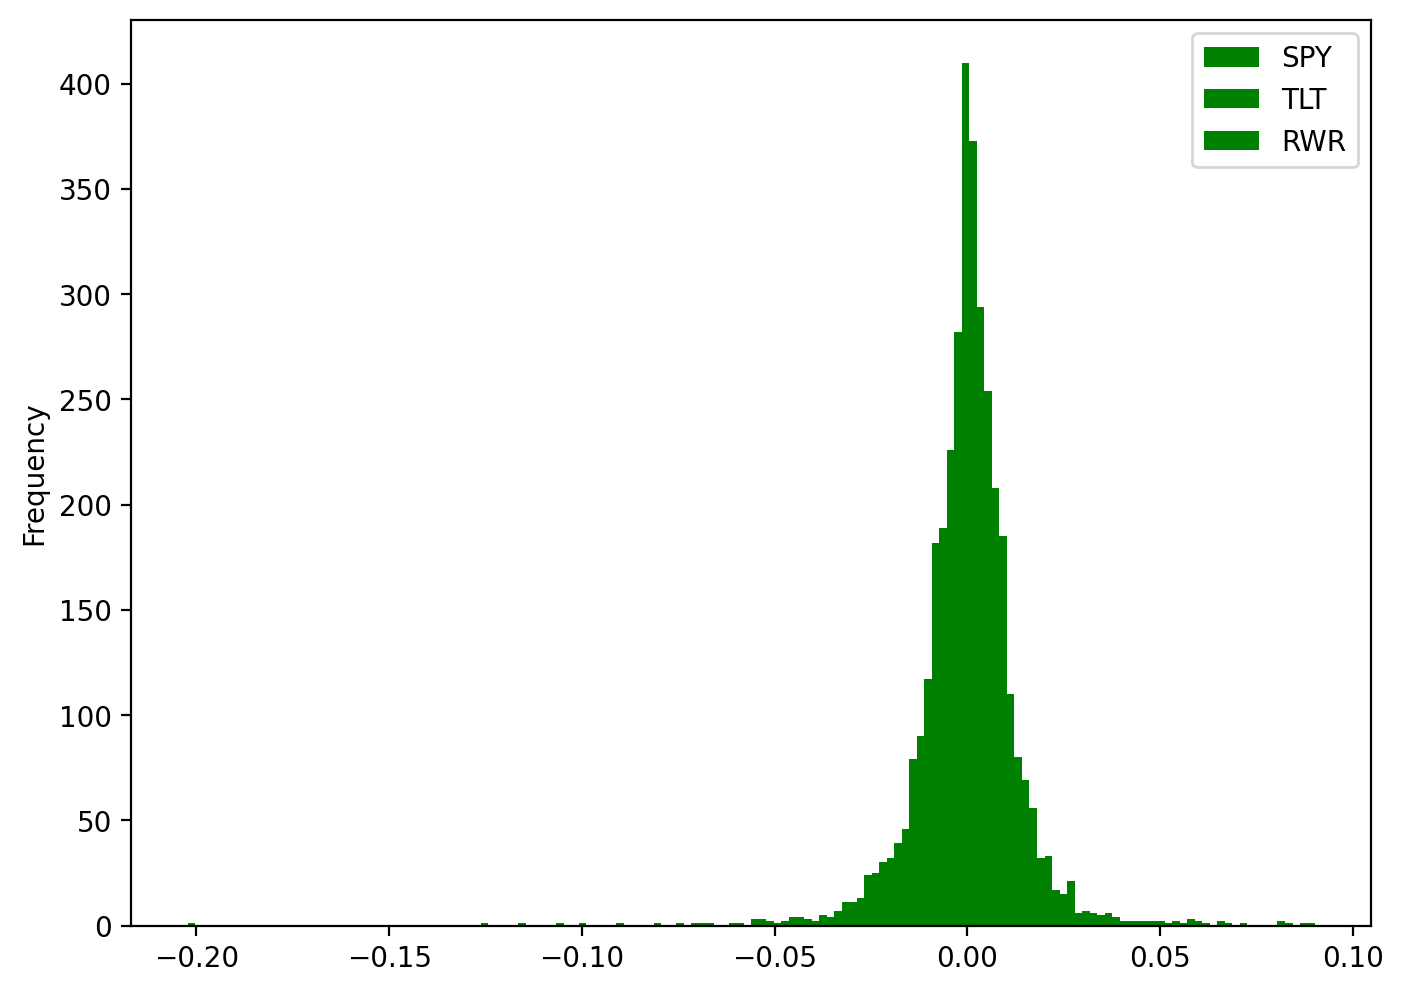

In [72]:
datasetreturns.plot(kind='hist', bins=150, color='green')